# Vector analysis over twitter posts

## Now let's do some mining on twitter

We use `faster-than-requests` becaue is new, fast and fancy

In [0]:
try:
  import faster_than_requests as req
except:
  !pip install faster-than-requests
  import faster_than_requests as req

we upgrade gensim at this point we we won't have to restart the runtime after we get the data in

In [0]:
!pip install --upgrade gensim

Here we import the packages we need, good to know we use `fake_useragent` to change the `User-Agent` in the `header` of each request to make it look like IE7. Thus it will force Twitter to go into the old web version without the web component based front-end and easy to crawl

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
try:
  from fake_useragent import UserAgent
except:
  !pip install fake_useragent
  from fake_useragent import UserAgent
from os.path import exists
import urllib.parse

More utils which are going to be used later, please use TF <=2.0 

In [0]:
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt') 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here is the fancy trick with the user agent

In [0]:
req.set_headers([
    ('User-Agent', UserAgent().ie)             
])

So here we have:

* `twitter_selectors` a dictionary with the `css` selectors for each tweet

* `get_soup` is sending a get request to get the html content from the url right into the `BeautifulSoup` html parser creating a object which I call soup

* `get_tweets` is using a `soup` to extract the `username` and `content` of each tweet

* `get_tweets_df` finally this function is using all functions from above into a `loop` to mine all the tweets and returning a pandas dataframe 

In [0]:
twitter_selectors = {
    'post': '.tweet',
#    'full_name': '.fullname',
    'username': '.username',
    'content': '.tweet-text'
    
}

def get_soup(url):
    return BeautifulSoup(req.get2str(url),'html.parser')
    
def get_tweets(soup):
    tweets = list()
    for tweet in soup.select(twitter_selectors.get('post')):
        tweets.append({
                'username': tweet.select_one(twitter_selectors.get('username')).text,
                'content': tweet.select_one(twitter_selectors.get('content')).text,
        })
        
    return tweets
    
def get_tweets_df(keyword,limit=None):
    url = f'https://mobile.twitter.com/search?q={urllib.parse.quote_plus(keyword)}'
    tweets = []
    stop = False
    while(stop != True):
        try:
          soup = get_soup(url=url)
          tweets+=get_tweets(soup=soup)
          next = soup.select_one('.w-button-more a')
          if next:
              url = 'https://mobile.twitter.com' + next['href']
          else:
              stop = True
        except:
          continue

        if limit != None and limit <= tweets.__len__():
          stop = True
          
            
    print(f'{tweets.__len__()} tweets has been crawled')  
    return pd.DataFrame.from_dict(tweets)

Then we call it with a `1000` tweets limit to get all the tweets for the related topic, in our case `coronavirus`. Since we are mining by tweets/page we get a few more tweets.

In [0]:
%%time
df = get_tweets_df('coronavirus',limit = 1000)

1015 tweets has been crawled
CPU times: user 2.45 s, sys: 43.4 ms, total: 2.5 s
Wall time: 27.5 s


Further on we use this lambda function to remove any `breakline` `@` and `#`

In [0]:
df = df.apply(lambda x: x.str.replace('\n','').replace('@','').replace('#',''),axis=1)

## Sentence Embeddings of tweets content

Now we use this [Universal Sentence Encoder](https://tfhub.dev.google/universal-sentence-encoder/4) to get the sentence embeddings from the tweets content

In [0]:
embd = hub.load(f"https://tfhub.dev/google/universal-sentence-encoder/4")
def embed(sentences):
  return np.array(embd(tf.squeeze(tf.cast(sentences, tf.string))))

We save it as a column

In [0]:
df['content_sent_vects'] = embed(df.content.values).tolist()

In [0]:
df

,username,content,content_wordlist,content_sent_vects
0,@allkpop,Jaejoong facing possible punishment by KCDC ...,NaN,"[-0.07023757696151733, 0.04490802809596062, -0..."
1,@Corona_Bot__,CONFIRMED: Barney tests positive for Coronav...,NaN,"[0.05011240020394325, -0.031166449189186096, -..."
2,@nytimes,The Korean star known as Jaejoong of the K-p...,NaN,"[-0.01596658118069172, 0.04994076490402222, 0...."
3,@PIB_India,Approx 1800 people related to #TablighJamaat...,NaN,"[-0.06460247933864594, 0.05959327518939972, -0..."
4,@SkyNews,Coronavirus: Woman fined £650 for refusing t...,NaN,"[-0.05083870142698288, 0.03122670203447342, 0...."
...,...,...,...,...
1010,@ASlavitt,Andy Slavitt: slowing spread of coronavirus ...,NaN,"[0.02724810130894184, -0.002946038730442524, 0..."
1011,@fred_guttenberg,Many reasons that I wish @JoeBiden were Pres...,NaN,"[0.04280007258057594, -0.05422208085656166, 0...."
1012,@FOXLA,"Coronavirus droplets could travel 27 feet, wa...",NaN,"[0.03585874289274216, 0.06049816682934761, 0.0..."
1013,@joncoopertweets,Fox News purportedly bracing for “legal bloo...,NaN,"[0.03799957036972046, 0.0289924293756485, -0.0..."


## LDA model

More packages

In [0]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import spacy
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from os.path import exists
import requests, zipfile, io
import os

I've put together a class following this [tutorial](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) to handler easier the LDA model, still having some issues with the mallet model inside of the colab, but I guess I will try to sort that out later

Nothing very fancy here, just building and storing everytning in a class, as further on we might need to reuse `bigrams` or `trigrams`. It is not the best approach as it is using loads of other packages inside so passing arugments into a constructor to initialise or change each module parameters might be pain so for the moment we will stick with this configuration and hopefully we can find a fast way to work with the mallet model.

In [0]:
class LDA:

  def __init__(self,sentences,mallet=False):
      self.sentences = sentences
      self.bigram = Phrases(self.sentences, min_count=5, threshold=100) # higher threshold fewer phrases.
      self.trigram = Phrases(self.bigram[self.sentences], threshold=100)  
      self.bigram_mod = Phraser(self.bigram)
      self.trigram_mod = Phraser(self.trigram)
      self.stop_words = stopwords.words('english')
      self.nlp = spacy.load('en', disable=['parser', 'ner'])
      self.download_mallet_path = 'http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip'
      self.mallet_path = '/content/mallet-2.0.8/bin/mallet'
      self.ldamallet = None
      self.ldamallet = None
      self.topics = None
      self.java_installed = False

      os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'

      
      ######################
      self.make()

      # if mallet:
      #   self.build_ldamallet()
      # else:
      #   self.build_lda()
      ######################

  def remove_stopwords(self):
      self.sent_no_stops =  [[word for word in simple_preprocess(str(doc)) if word not in self.stop_words] for doc in self.sentences]

  def make_bigrams(self):
      self.bigram_data = [self.bigram_mod[doc] for doc in self.sent_no_stops]

  def make_trigrams(self):
      self.trigram_data = [self.trigram_mod[self.bigram_mod[doc]] for doc in self.sent_no_stops]

  def lemmatization(self, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
      self.lemm_sentences = [ [token.lemma_ for token in self.nlp(" ".join(sent)) if token.pos_ in allowed_postags] for sent in self.bigram_data]

  def dictionary(self):
      self.id2word = corpora.Dictionary(self.lemm_sentences)

  def corpus(self):
      self.corpus = [self.id2word.doc2bow(text) for text in self.lemm_sentences]

  def make(self):
      self.remove_stopwords()
      self.make_bigrams()
      self.make_trigrams()
      self.lemmatization()
      self.dictionary()
      self.corpus()

  def build_lda(self,num_topics=20,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto'):
      self.lda_model = LdaModel(
                      corpus=self.corpus,
                      id2word=self.id2word,
                      num_topics=num_topics, 
                      random_state=random_state,
                      update_every=update_every,
                      chunksize=chunksize,
                      passes=passes,
                      alpha=alpha,
                      per_word_topics=True)
      



  def download_mallet(self):
      r = requests.get(self.download_mallet_path)
      z = zipfile.ZipFile(io.BytesIO(r.content))
      z.extractall()

      if not self.java_installed:
        self.install_java()


  def install_java(self):
      !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
      os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
      !java -version       #check java version
      

  def build_ldamallet(self,num_topics=20):
      if not exists(self.mallet_path):
        self.download_mallet()
      self.ldamallet = LdaMallet(self.mallet_path, corpus=self.corpus, num_topics=num_topics, id2word=self.id2word)

  def coherence_score(self,mallet=False):
      if mallet:
        pprint(self.ldamallet.show_topics(formatted=False))
        md = self.ldamallet
      else:
        md = self.lda_model
        pprint(self.lda_model.print_topics())
      

      coherence_model = CoherenceModel(model=md, texts=self.lemm_sentences, dictionary=self.id2word, coherence='c_v')
      coh = coherence_model.get_coherence()
      print('\nCoherence Score: ', coh)



  def compute_coherence_values(self, limit, start=2, step=3, mallet=False):
      coherence_values = []
      
      for num_topics in range(start, limit, step):
          if mallet:
            self.build_ldamallet(num_topics=num_topics)
            md = self.ldamallet
          else:
            self.build_lda(num_topics=num_topics)
            md = self.lda_model
          coherencemodel = CoherenceModel(model=md, texts=self.lemm_sentences, dictionary=self.id2word, coherence='c_v')
          coherence_values.append({
              'num_topics': num_topics,
              'coherence': coherencemodel.get_coherence()
          })

      return coherence_values


We create an object of our `LDA` class and passing the raw sentences as a list. Then we compute a coherence search for the best number of topics related to our content. However since those tweets are mined, this process might have different results on each new data. 

In [0]:
%%time
ld = LDA(df.content.values.tolist())
ld_coherence_values = ld.compute_coherence_values(start=2, limit=40, step=6)
pprint(ld_coherence_values)

[{'coherence': 0.24454476285561758, 'num_topics': 2},
 {'coherence': 0.46119096489624833, 'num_topics': 8},
 {'coherence': 0.4516224532223637, 'num_topics': 14},
 {'coherence': 0.42736241847827366, 'num_topics': 20},
 {'coherence': 0.3930428008422175, 'num_topics': 26},
 {'coherence': 0.4105924951482943, 'num_topics': 32},
 {'coherence': 0.39407950264156383, 'num_topics': 38}]
CPU times: user 34.9 s, sys: 183 ms, total: 35.1 s
Wall time: 35.2 s


From the previous search we found the best number of topics, which now we are using to rebuild the model and show the topics we found.

In [0]:
ld.build_lda(num_topics=8)
ld.lda_model.print_topics()

[(0,
  '0.148*"com" + 0.075*"twitter" + 0.061*"pic" + 0.046*"virus" + 0.032*"go" + 0.026*"people" + 0.022*"corona" + 0.018*"test" + 0.018*"make" + 0.018*"day"'),
 (1,
  '0.026*"would" + 0.025*"fight" + 0.021*"die" + 0.019*"watch" + 0.018*"turn" + 0.017*"hard" + 0.016*"leader" + 0.016*"thank" + 0.013*"presidential" + 0.013*"bar"'),
 (2,
  '0.036*"week" + 0.027*"tell" + 0.023*"see" + 0.019*"official" + 0.018*"tough" + 0.017*"break" + 0.015*"story" + 0.015*"worker" + 0.014*"end" + 0.014*"good"'),
 (3,
  '0.025*"shift" + 0.022*"use" + 0.018*"slow" + 0.017*"do" + 0.017*"state" + 0.016*"company" + 0.015*"truth" + 0.015*"crisis" + 0.015*"few" + 0.015*"time"'),
 (4,
  '0.037*"say" + 0.031*"today" + 0.029*"doctor" + 0.028*"many" + 0.028*"want" + 0.024*"nurse" + 0.021*"work" + 0.015*"can" + 0.013*"american" + 0.012*"job"'),
 (5,
  '0.069*"trump" + 0.027*"country" + 0.017*"tirelessly" + 0.016*"join" + 0.016*"term" + 0.014*"enemy" + 0.014*"view" + 0.013*"concerned" + 0.013*"republican" + 0.012*"na

## Graph Clustering

We use the `cosine similarity` on the extracted `vectors` to create a `similarity matrix`

In [0]:
%%time
similarity_matrix = cosine_similarity(df.content_sent_vects.values.tolist())

CPU times: user 2.88 s, sys: 150 ms, total: 3.03 s
Wall time: 1.96 s


We put this together into a dataframe with the `username` as columns and index thus it will look quite similar with a correlation dataframe or heatmap

In [0]:
simdf = pd.DataFrame(
    similarity_matrix,
    columns = df.username.values.tolist(),
    index = df.username.values.tolist()
)

However we want this unstacked to make make it easier to pass into our graph, also we've kept just the username as each one is unique

So here you can see the similarity between the content of each user

In [0]:
long_form = simdf.unstack()
# rename columns and turn into a dataframe
long_form.index.rename(['t1', 't2'], inplace=True)
long_form = long_form.to_frame('sim').reset_index()
long_form = long_form[long_form.t1 != long_form.t2]
long_form[:3]

,t1,t2,sim
1,@AdamSchefter,@NorbertElekes,0.133930
2,@AdamSchefter,@BreitbartNews,0.295476
3,@AdamSchefter,@DarylDust,0.150086


Here we want to select the similarity treshold to filter the tweets and create our graph from the formatted dataframe

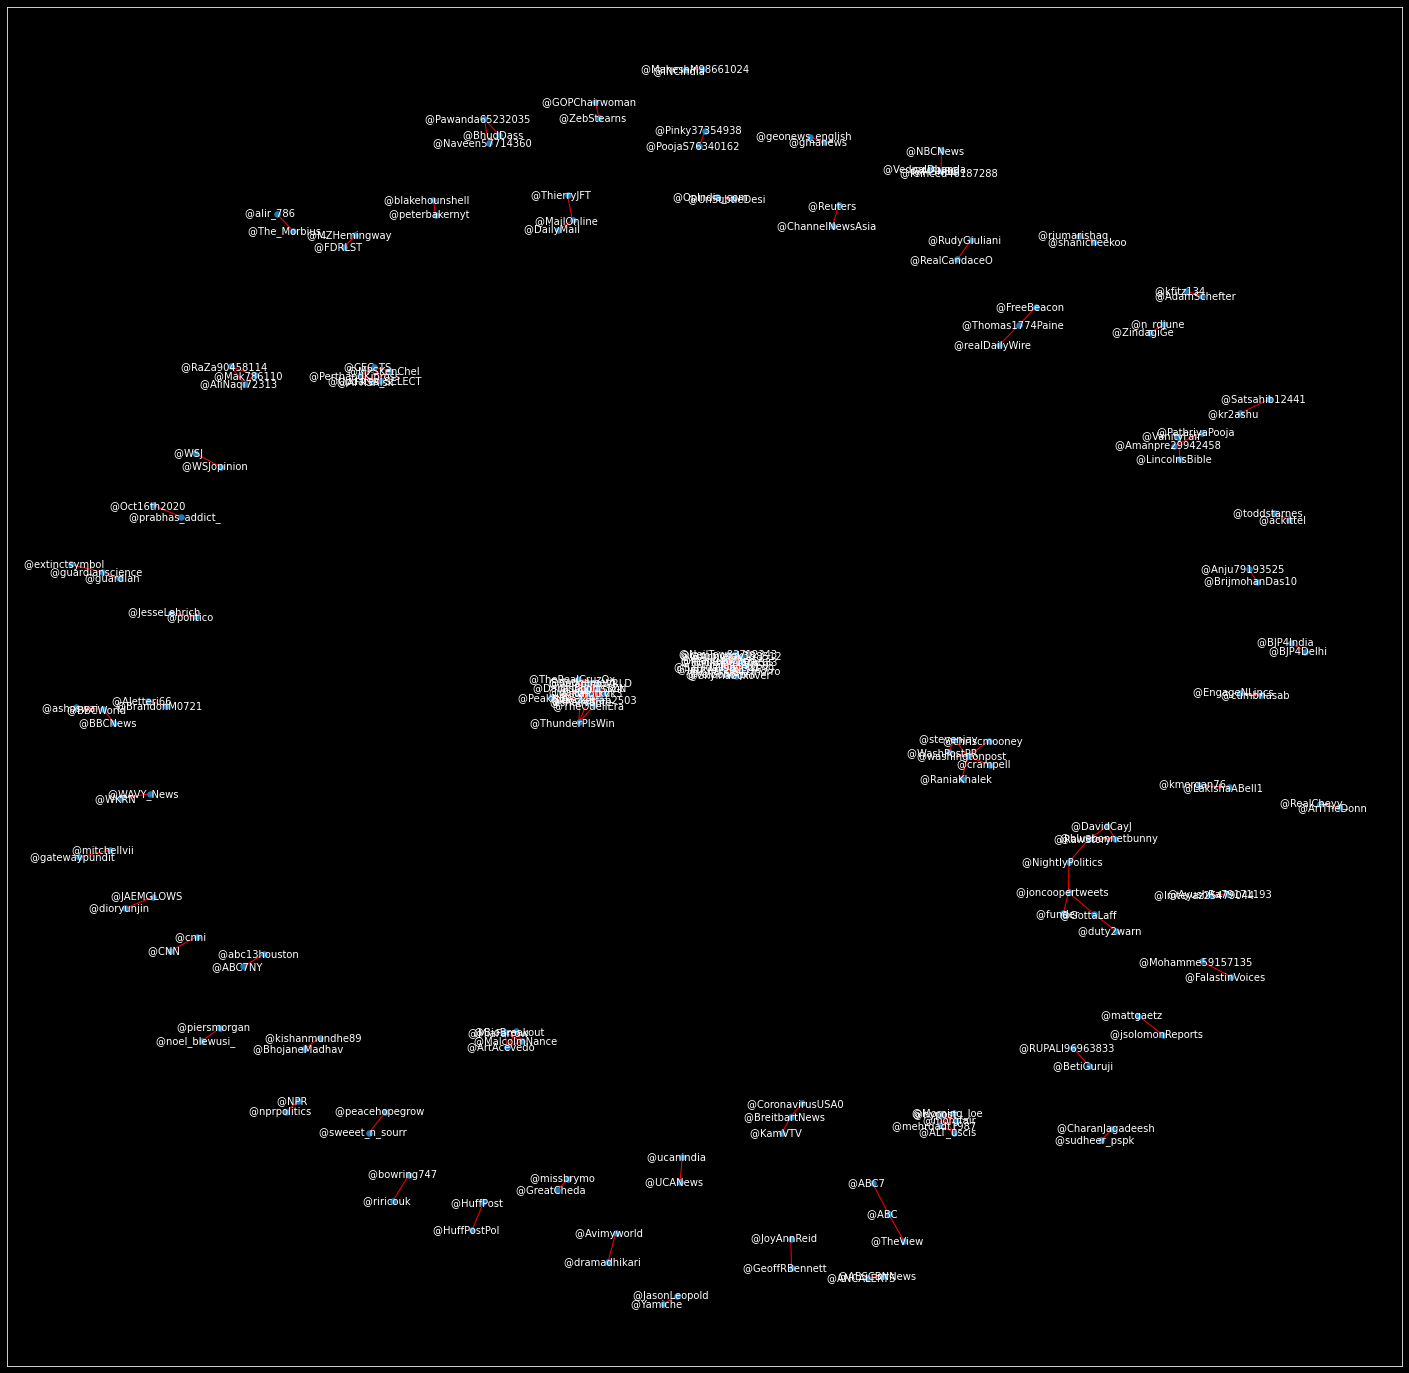

In [0]:
sim_weight = 0.95
gdf = long_form[long_form.sim > sim_weight]
plt.figure(figsize=(25,25))
pd_graph = nx.Graph()
pd_graph = nx.from_pandas_edgelist(gdf, 't1', 't2')
pos = nx.spring_layout(pd_graph)
nx.draw_networkx(pd_graph,pos,with_labels=True,font_size=10,font_color='#fff',edge_color='#f00',node_size = 30)

Now we get the connected components into a dataframe

In [0]:
l=list(nx.connected_components(pd_graph))

L=[dict.fromkeys(y,x) for x, y in enumerate(l)]

d=[{'users':k , 'groups':v }for d in L for k, v in d.items()]

In [0]:
gcd = pd.DataFrame.from_dict(d)

Here is the number of `groups` or `clusters` we have extracted for the chosen similarity treshold

In [0]:
gcd.groups.nunique()

65

We add the content for each user into the grouped dataframe

In [0]:
gcd['content'] = gcd.users.apply(lambda x: df[df.username==x].content.values.tolist()[0] )
gcd[:5]

,users,groups,content
0,@AdamSchefter,0,Cardinals All-Pro linebacker Chandler Jones ...
1,@kfitz134,0,Cardinals All-Pro linebacker Chandler Jones ...
2,@Aletteri66,1,The Corona virus can’t kill me because I alr...
3,@BrandonM0721,1,"The Corona Virus can’t kill me, I already di..."
4,@realDailyWire,2,Epidemiologist Behind Highly-Cited Coronavir...


## Word Clouds for the tweets

We use a `nltk` tokenizer to extract just the words and remove the `stop words`

In [0]:
tok = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english')) 
def clean(string):
    return " ".join([w for w in word_tokenize(" ".join(tok.tokenize(string))) if not w in stop_words])

gcd.content = gcd.content.apply(lambda x: clean(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Our `big_groups` is a list of `indexes` from our grouped dataset with the index of the top 12 `groups` sorted `descending`.

Then we iterate through these `indexes` and create WordCloud of each group whihc is stored in the `clouds` dictionary

In [0]:
%%time
clouds = dict()

big_groups = pd.DataFrame({
    'counts':gcd.groups.value_counts()
    }).sort_values(by='counts',ascending=False)[:12].index.values.tolist()

for group in big_groups:
    text = gcd[gcd.groups == group].content.values
    wordcloud = WordCloud(width=1000, height=1000).generate(str(text))
    clouds[group] = wordcloud

CPU times: user 28.7 s, sys: 581 ms, total: 29.3 s
Wall time: 29.4 s


In [0]:
def plot_figures(figures, nrows = 1, ncols=1):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=(20,20))
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(f'Most Freqent words for the group {title+1}')
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

Then we plot them with the help of our `plot_figures` function

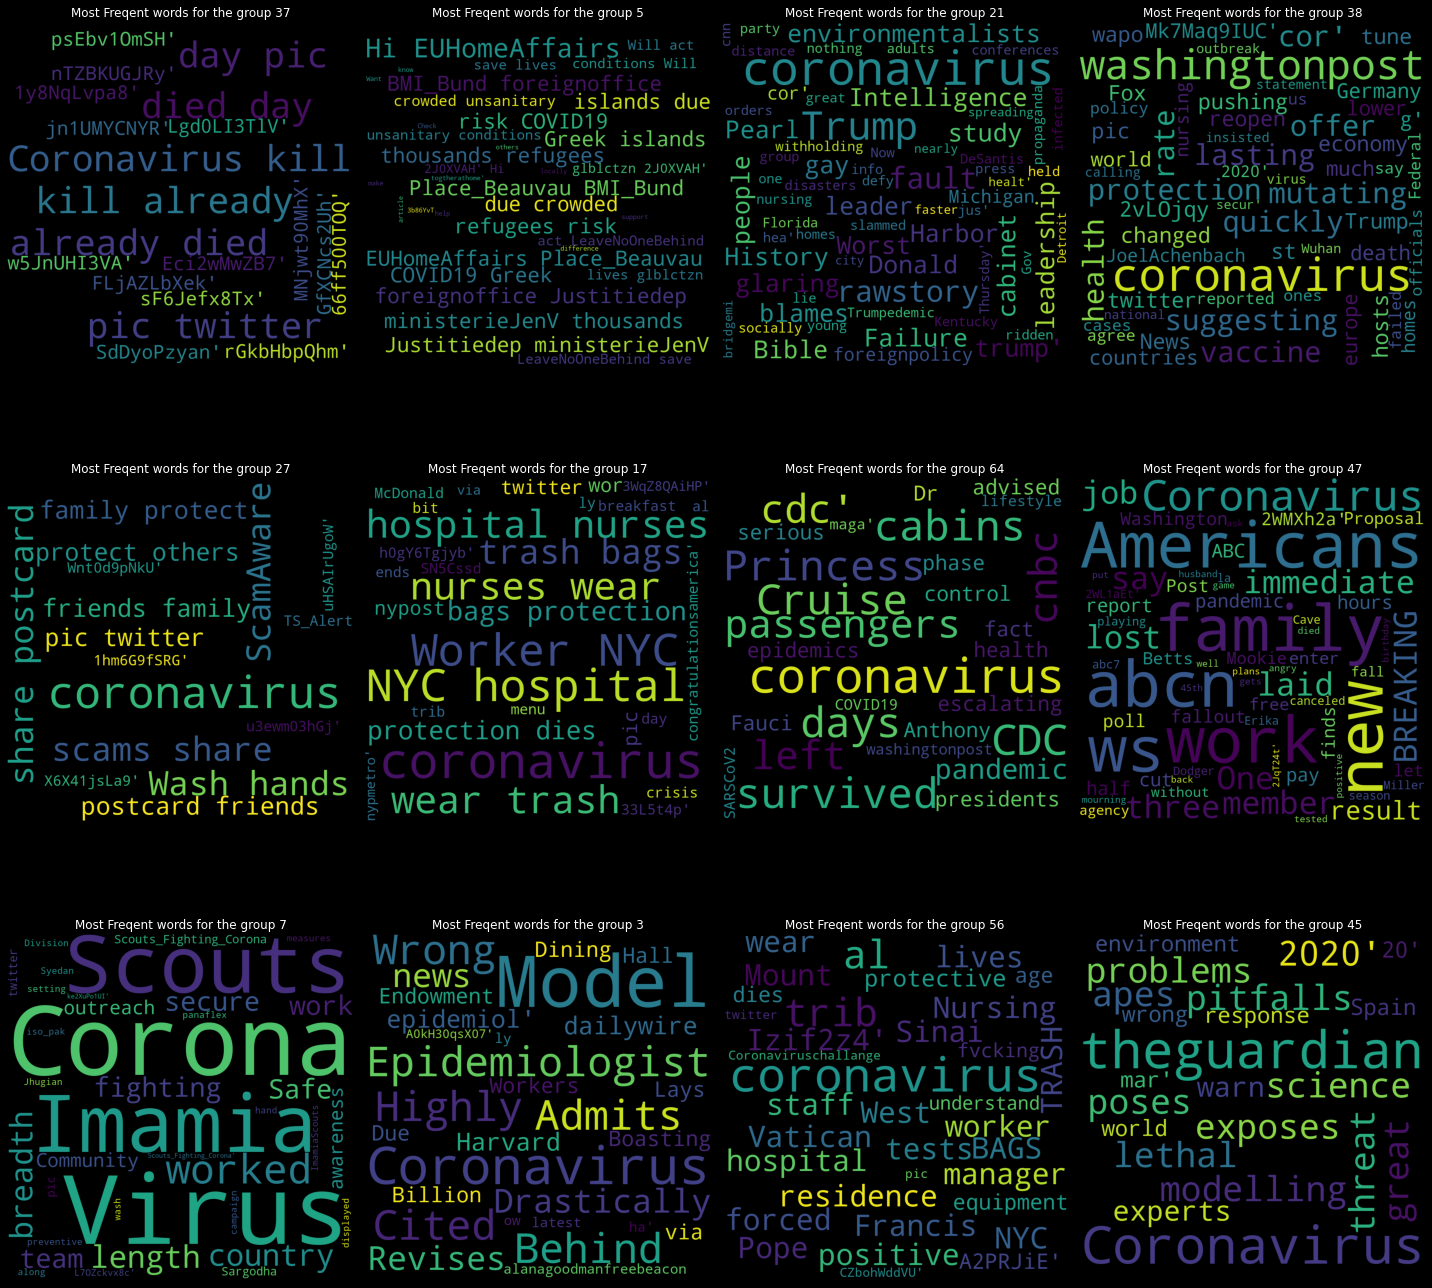

In [0]:
plt.style.use("dark_background")
plot_figures(clouds, 3, 4)
plt.show()